In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score
import keras.optimizers

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'

# **1.데이터 준비**

## Train dataset

In [2]:
# 데이터 load
raw_train= pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')
raw_train.head(25)

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105
5,2013-01-01,6,A,2390.961
6,2013-01-01,7,A,2378.457
7,2013-01-01,8,A,2518.921
8,2013-01-01,9,A,2706.481
9,2013-01-01,10,A,2832.057


In [3]:
# 데이터 자료형 전처리
# 구분 확인
raw_train['구분'].unique()

# string object -> datetime 
raw_train['연월일'] = pd.to_datetime(raw_train['연월일'], format = '%Y-%m-%d')

# datetime + 시간 
## 시간 int -> flaot (datetime 더하기 할려면 필요)
raw_train = raw_train.astype({'시간':'float64'})
raw_train['연월일시'] = [raw_train['연월일'][i]+ timedelta(hours = raw_train['시간'][i]-1) for i in range(len(raw_train))]
#print(raw_df.head())
raw_train.to_csv("./data/raw_train.csv")
'''
# 연월일시 나눠서 컬럼 생성
raw_df['year'] = [raw_df['연월일시'][i].year for i in range(len(raw_df))]
raw_df['month'] = [raw_df['연월일시'][i].month for i in range(len(raw_df))]
raw_df['day'] = [raw_df['연월일시'][i].day for i in range(len(raw_df))]
raw_df['hour'] = [raw_df['연월일시'][i].hour for i in range(len(raw_df))]
#print(raw_df.tail())
'''
#raw_train

df = raw_train.set_index(raw_train['연월일시']).loc[:, ['구분', '공급량']]
df

,구분,공급량
연월일시,,
2013-01-01 00:00:00,A,2497.129
2013-01-01 01:00:00,A,2363.265
2013-01-01 02:00:00,A,2258.505
2013-01-01 03:00:00,A,2243.969
2013-01-01 04:00:00,A,2344.105
...,...,...
2018-12-31 19:00:00,H,681.033
2018-12-31 20:00:00,H,669.961
2018-12-31 21:00:00,H,657.941


## Test dataset

In [5]:
# test 데이터 load
raw_test = pd.read_csv('./data/raw_test.csv')
raw_test.head()

# 일자, 시간, 구분 분리
raw_test['일자'] = raw_test['일자|시간|구분'].str.split(' ').str[0]
raw_test['시간'] = raw_test['일자|시간|구분'].str.split(' ').str[1].astype(int)
raw_test['구분'] = raw_test['일자|시간|구분'].str.split(' ').str[2]
raw_test

# 원래 column 제거
raw_test.drop(columns='일자|시간|구분', inplace=True)
raw_test

# string object -> datetime 
raw_test['일자'] = pd.to_datetime(raw_test['일자'], format = '%Y-%m-%d')

# datetime + 시간 
## 시간 int -> flaot (datetime 더하기 할려면 필요)
raw_test = raw_test.astype({'시간':'float64'})
raw_test['일자'] = [raw_test['일자'][i]+ timedelta(hours = raw_test['시간'][i]-1) for i in range(len(raw_test))]

raw_test.head(25)

# 시점 데이터 index로 변경
test= raw_test.set_index(raw_test['일자'])

# 컬럼 선택 및 y 생성
test['공급량'] = pd.Series()
test = test.loc[:, ['구분', '공급량']]
test.to_csv("")
test

FileNotFoundError: [Errno 2] No such file or directory: './data/raw_test.csv'

# **2.시각화**

## 데이터셋 나누기 - 공급사별

In [ ]:
# 공급사별 numerical statistics
comp_lst = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
comp_dct = {name : pd.DataFrame() for name in comp_lst}

for cp in comp_lst:
  comp_dct[cp] = df.query(f"구분 == '{cp}'")

## 공급사별 Min Max Numerical Statistics

In [ ]:
for cp in comp_lst:
    print(f"---------------------- {cp} 공급사 ----------------------")
    print(f"{cp}공급사의 min = {comp_dct[cp]['공급량'].min()}")
    print(f"{cp}공급사의 max = {comp_dct[cp]['공급량'].max()}")


## 공급사별 Line Plot

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (40, 30), sharey = True)
ax_list = ax.reshape(8)
for i in range(7):
    idx = comp_lst[i]
    ax_list[i].plot(comp_dct[idx]['공급량'])
    ax_list[i].set_title(f'{idx}공급사 lineplot', fontsize = 40)
    ax_list[i].set_ylim(0, 5000)


- C와 H 공급사의 볼륨이 다른 공급사에 비해서 현저히 작게 유지 됌 
- 전체적으로 trend 는 없어보임 거의 미미한 수준

In [ ]:
# 연도
yr_lst = list(comp_dct['D'].index.year.unique())
yr_lst

In [ ]:
"""sns.lineplot(data = dataset, x = 'new 기준2', y = '공급량', hue = 'year')"""

In [ ]:
"""# 1년 내 공급사별 line plot
# D 공급사로 시범

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (40, 30), sharey = True)
ax_list = ax.reshape(8)
for i in range(7):
    idx = comp_lst[i]
    dataset = comp_dct[idx]
    dataset['year'] = list(dataset.index.year)
    dataset['기준']= list(dataset.index)
    dataset['new 기준'] = dataset['기준'].dt.strftime('%m-%d %H')
    
    sns.lineplot(data = dataset, x = 'new 기준', y = '공급량', hue = 'year', ax = ax_list[i])
    
    ax_list[i].plot(comp_dct[idx]['공급량'])
    ax_list[i].set_title(f'{idx}공급사 lineplot', fontsize = 40)
    #ax_list[i].set_ylim(0, 5000)
  """  

# **3. 이상치 처리**

## 1)정규분포 이용

In [ ]:
threshold = 5

outlier_A = [] 
mean = comp_dct['A']['공급량'].mean()
std = comp_dct['A']['공급량'].std()

for i in comp_dct['A']['공급량']: 
    z = (i-mean)/std 
    if z > threshold: 
        outlier_A.append(i) 

print('A 데이터셋 내의 이상값', len(outlier_A), '개') 

## 2) Decomposition 시도 - 공급사 D

In [ ]:
df_D = comp_dct['D']['공급량']

### STL Decomposition

In [ ]:
from statsmodels.tsa.seasonal import STL

In [ ]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

- raw data
- seasonal = (24*7*52)+1
- ternd = (24*30*6)+1

In [ ]:
df_A = df[df['구분'] == 'D']['공급량']
stl = STL(df_D)
res = stl.fit()
fig = res.plot()
plt.suptitle("D공급사 Decomposition plot 튜닝 전", fontsize = 35, y = 1.05)

In [ ]:
df_A = df[df['구분'] == 'D']['공급량']
stl = STL(df_D[:8760])
res = stl.fit()
fig = res.plot()
plt.suptitle("D공급사 Decomposition plot 튜닝 전 1년 sampling", fontsize = 35, y = 1.05)

#### BoxCox Transformation => log 10 

In [15]:
lg_df_D = stats.boxcox(df_D)[0]
lg_df_D = pd.Series(lg_df_D)
lg_df_D.index = df_D.index

#### 가져온 부분

In [16]:
def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [17]:
"""stl = STL(lg_df_D[:1000], period=24, robust=True)
res_robust = stl.fit()
fig = res_robust.plot()
res_non_robust = STL(lg_df_D, period=12, robust=False).fit()
add_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])"""

'stl = STL(lg_df_D[:1000], period=24, robust=True)\nres_robust = stl.fit()\nfig = res_robust.plot()\nres_non_robust = STL(lg_df_D, period=12, robust=False).fit()\nadd_stl_plot(fig, res_non_robust, ["Robust", "Non-robust"])'

In [18]:
"""stl = STL(df_D, period=12, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True)
res_deg_0 = stl.fit()
fig = res_robust.plot()
add_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])"""

'stl = STL(df_D, period=12, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True)\nres_deg_0 = stl.fit()\nfig = res_robust.plot()\nadd_stl_plot(fig, res_deg_0, ["Degree 1", "Degree 0"])'

#### 직접 STL Decomposition

##### (1) Transformed, period = 24, robust
- Box-Cox Transforamtion 적용

Text(0.5, 1.05, 'Transformed, period = 24, robust')

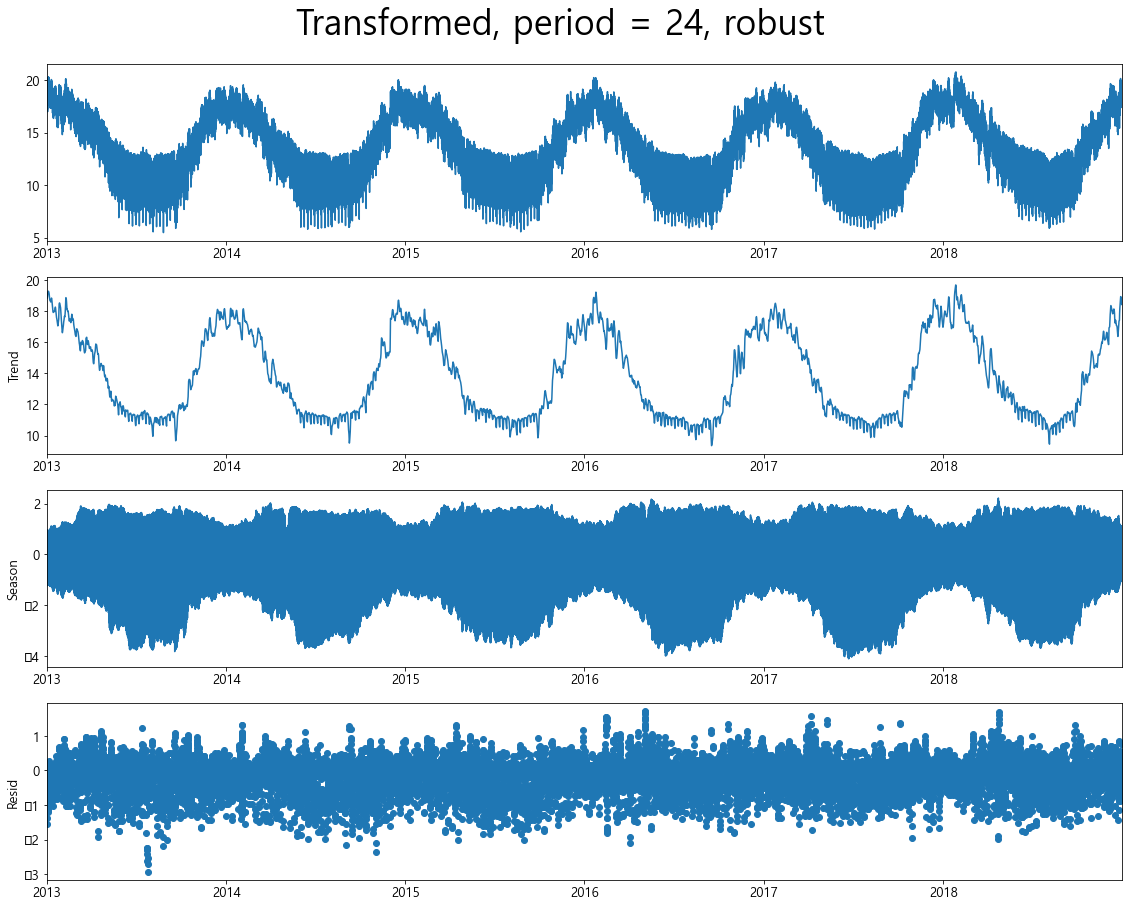

In [25]:
stl = STL(lg_df_D, period = 24, robust = True)
res = stl.fit()
fig = res.plot()
plt.suptitle("Transformed, period = 24, robust", fontsize = 35, y =1.05)

- trend compoment: too smoothed, no cyclic movement detected
- seasonal component: not clear 
- resid: cyclic?

In [ ]:
24*52*7

#### (2) Transformed, seasonal = 25, robust

Text(0.5, 1.05, 'Transformed, seasonal = 25, robust')

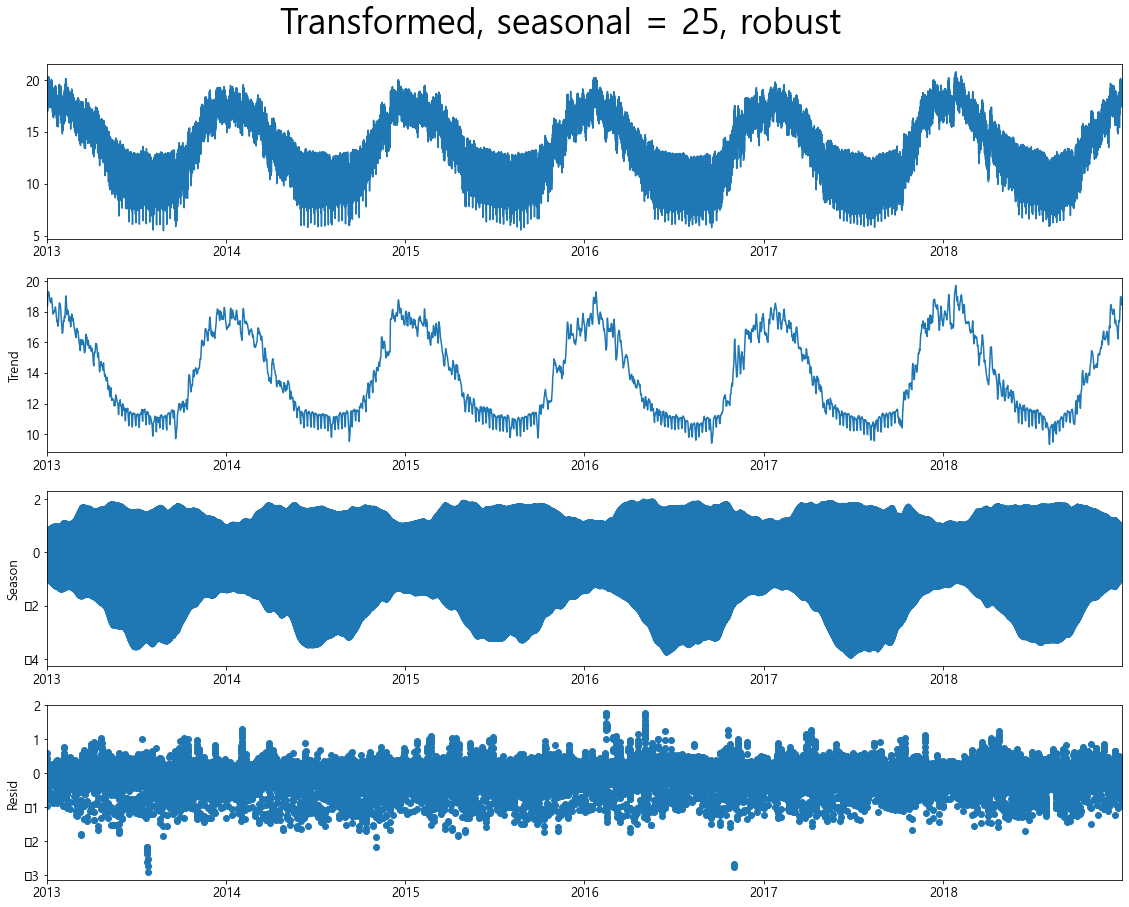

In [21]:
stl = STL(lg_df_D, seasonal = (24)+1, robust = True)
res = stl.fit()
fig = res.plot()
plt.suptitle("Transformed, seasonal = 25, robust", fontsize = 35, y = 1.05)

#### (3) Transformed, sampling 8760, seasonal = 24+1, robust True
- hoplefuly default trend parameter the cyclic movement 

Text(0.5, 1.05, 'Transformed, sampling 1 year+day, seasonal = 25, robust')

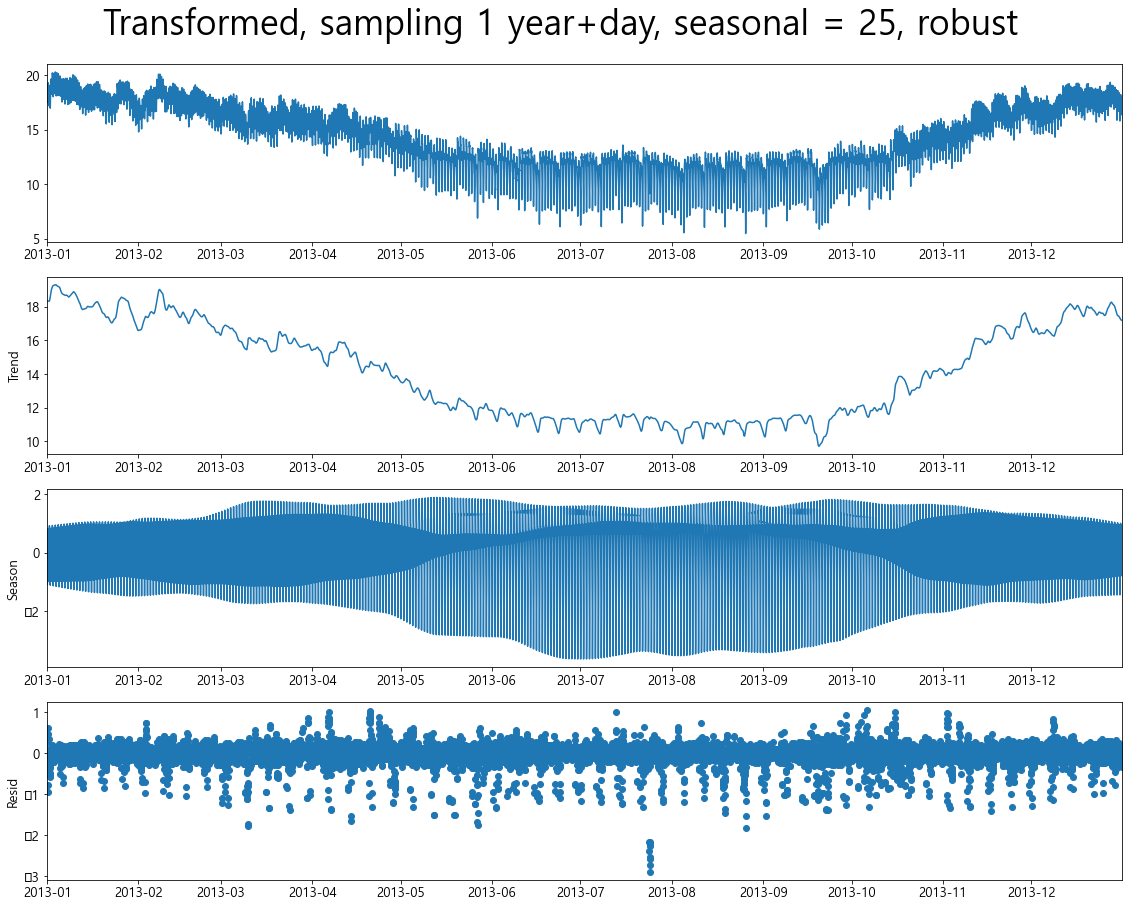

In [45]:
stl = STL(lg_df_D[:8760], seasonal = (24)+1, robust = True)
res = stl.fit()
fig = res.plot()
plt.suptitle("Transformed, sampling 1 year+day, seasonal = 25, robust", fontsize = 35, y = 1.05)

- residual 정규성검정

In [41]:
residual_A = res.resid
# shapiro test
sha_stat, sha_p = stats.shapiro(residual_A)
print("=="*50)
print("<The result of Shaprio Test>")
if sha_p < 0.05:
    print(f"  Test statistic: {sha_stat}, p-value: {sha_p:.9f}, therefore, reject the null ")
else:
    print(f"Test statistic: {sha_stat}, p-value: {sha_p}, therefore, fail to reject the null")

# D'Agostino's k^2 Test
k2_stat, k2_p = stats.normaltest(residual_A)
print("=="*50)
print("<The result of D'Agostino's K^2 Test>")
if k2_p < 0.05:
    print(f"  Test statistic: {k2_stat}, p-value: {k2_p:.9f}, therefore, reject the null ")
else:
    print(f"Test statistic: {k2_stat}, p-value: {k2_p}, therefore, fail to reject the null")

<The result of Shaprio Test>
  Test statistic: 0.815270185470581, p-value: 0.000000000, therefore, reject the null 
<The result of D'Agostino's K^2 Test>
  Test statistic: 4641.904486970503, p-value: 0.000000000, therefore, reject the null 


- 6 sigma outlier 제외

In [46]:
# 기준 = 6 outlier dectection
threshold = 6

outlier_D = [] 
mean = res.resid.mean()
std = res.resid.std()

for i in res.resid: 
    z = (i-mean)/std 
    if np.abs(z) > threshold: 
        outlier_D.append(i) 

print('데이터셋 내의 이상값', len(outlier_D), '개') 
print("====="*20)
print(outlier_D)

데이터셋 내의 이상값 14 개
[-1.7308744926557154, -1.7784511900629898, -1.691035169062495, -1.7539320777203553, -2.3821064053184067, -2.160525888250186, -2.22161973972597, -2.1675950476833776, -2.2679199946107875, -2.5891708592565, -2.896818255537166, -2.728121643396916, -2.5322685244417844, -1.8290105213831467]


In [47]:
# outlier index 뽑아내기 
test1 = res.resid

outlier_D_index = [test1[test1 == item] for item in outlier_D]
outlier_D_index

[연월일시
 2013-03-10 06:00:00   -1.730874
 Name: resid, dtype: float64,
 연월일시
 2013-03-10 07:00:00   -1.778451
 Name: resid, dtype: float64,
 연월일시
 2013-05-27 01:00:00   -1.691035
 Name: resid, dtype: float64,
 연월일시
 2013-05-27 02:00:00   -1.753932
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 09:00:00   -2.382106
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 10:00:00   -2.160526
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 11:00:00   -2.22162
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 12:00:00   -2.167595
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 13:00:00   -2.26792
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 14:00:00   -2.589171
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 15:00:00   -2.896818
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 16:00:00   -2.728122
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 17:00:00   -2.532269
 Name: resid, dtype: float64,
 연월일시
 2013-08-26 02:00:00   -1.829011
 Name: resid, dtype: float64]

Text(0.5, 0.95, 'D공급사 Decomposition plot with BoxCox Transformation')

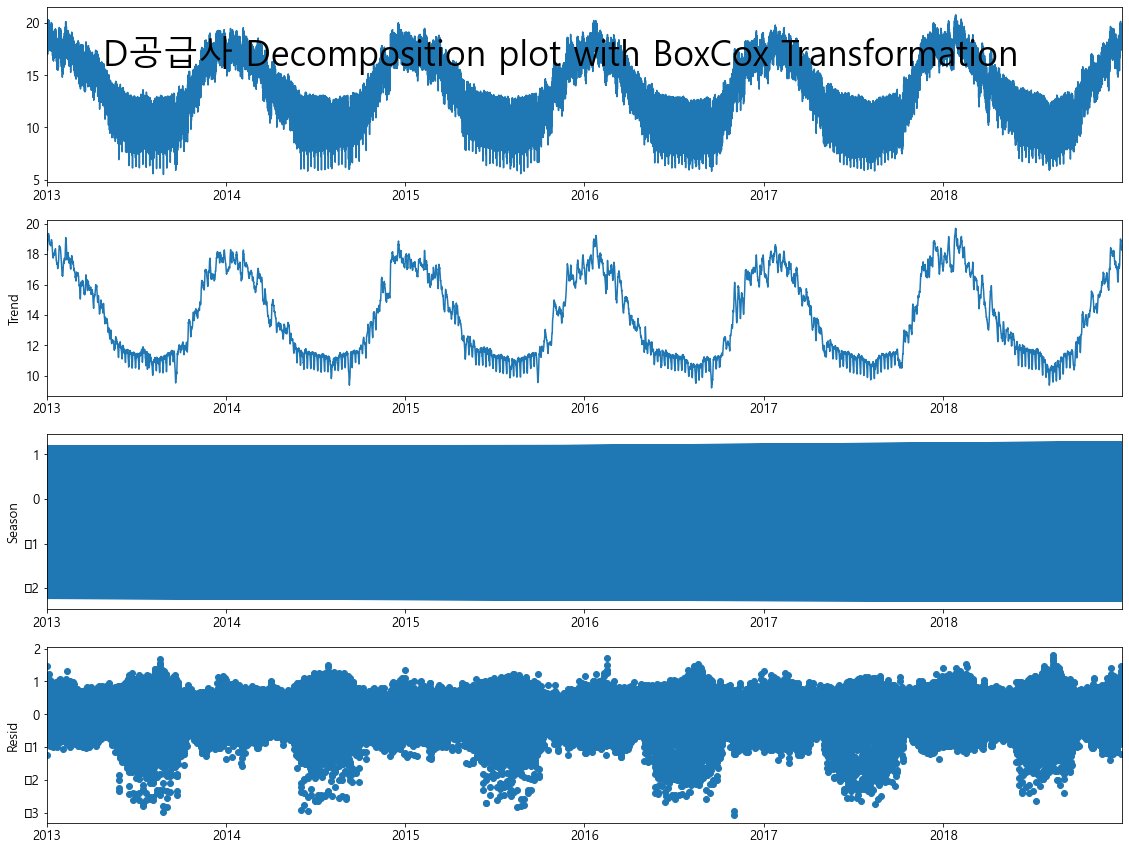

In [30]:
stl = STL(lg_df_D, period = 24, seasonal = (24*7*52)+1, robust = True)
res = stl.fit()
fig = res.plot()
plt.suptitle("D공급사 Decomposition plot with BoxCox Transformation", fontsize = 35, y = 0.95)

#### Residaul 정규성 검사

In [182]:
residual_A = res_robust.resid
# shapiro test
sha_stat, sha_p = stats.shapiro(residual_A)
print("=="*50)
print("The result of Shaprio Test")
if sha_p < 0.05:
    print(f"  Test statistic: {sha_stat}, p-value: {sha_p}, therefore, reject the null ")
else:
    print(f"Test statistic: {sha_stat}, p-value: {sha_p}, therefore, fail to reject the null")

# D'Agostino's k^2 Test
k2_stat, k2_p = stats.normaltest(residual_A)
print("=="*50)
print("The result of D'Agostino's K^2 Test")
if k2_p < 0.05:
    print(f"  Test statistic: {k2_stat}, p-value: {k2_p}, therefore, reject the null ")
else:
    print(f"Test statistic: {k2_stat}, p-value: {k2_p}, therefore, fail to reject the null")

The result of Shaprio Test
  Test statistic: 0.7737036943435669, p-value: 0.0, therefore, reject the null 
The result of D'Agostino's K^2 Test
  Test statistic: 20664.394304777517, p-value: 0.0, therefore, reject the null 


- null: dats follows noraml x ~ N(0, 1)


### outlier filtering comp D

In [110]:
res_robust.resid

연월일시
2013-01-01 00:00:00   -235.183913
2013-01-01 01:00:00   -136.216928
2013-01-01 02:00:00   -146.454706
2013-01-01 03:00:00   -231.017455
2013-01-01 04:00:00   -272.500763
                          ...    
2018-12-31 19:00:00     13.107005
2018-12-31 20:00:00      8.279232
2018-12-31 21:00:00     15.915407
2018-12-31 22:00:00      5.975644
2018-12-31 23:00:00    -87.486776
Name: resid, Length: 52584, dtype: float64

In [190]:
# 기준 = 6 outlier dectection
threshold = 6

outlier_D = [] 
mean = res_robust.resid.mean()
std = res_robust.resid.std()

for i in res_robust.resid: 
    z = (i-mean)/std 
    if np.abs(z) > threshold: 
        outlier_D.append(i) 

print('데이터셋 내의 이상값', len(outlier_D), '개') 
print("====="*20)
print(outlier_D)

데이터셋 내의 이상값 35 개
<built-in method sort of list object at 0x000001C63C4F5D80>


In [193]:
outlier_D

[-1.9243748961390281,
 -2.422619397504258,
 -2.255506384204173,
 -2.3001581040129206,
 -2.2398192741903955,
 -2.2754659641465675,
 -2.620731007144917,
 -2.933607102779968,
 -2.6961835708915007,
 -2.531690588143853,
 -1.8580461273061477,
 -1.9174453426644895,
 -2.19745280020431,
 -2.0267064106276873,
 -1.8982116680721823,
 -1.8588458357635407,
 -1.987380289859713,
 -1.9932679920888088,
 -2.1467531515741047,
 -1.8499359016322394,
 -1.9553984037545806,
 -2.0936474157228275,
 -2.364651742437797,
 -2.002743575747214,
 -1.8451273082083137,
 -1.8371772452800563,
 -1.8529825680020195,
 -2.02420374644084,
 -2.112623767155201,
 -1.9335434759280172,
 1.7213422825555682,
 -1.9533859484889664,
 -1.9045241115557872,
 -1.9865638219548831,
 1.7055765995667738]

In [185]:
test1

연월일시
2013-01-01 00:00:00   -0.347144
2013-01-01 01:00:00   -0.069187
2013-01-01 02:00:00   -0.120086
2013-01-01 03:00:00   -0.411404
2013-01-01 04:00:00   -0.503510
                         ...   
2018-12-31 19:00:00    0.009755
2018-12-31 20:00:00   -0.012680
2018-12-31 21:00:00   -0.001132
2018-12-31 22:00:00   -0.032338
2018-12-31 23:00:00   -0.342992
Name: resid, Length: 52584, dtype: float64

Text(0.5, 1.0, 'Scatterplot of residual')

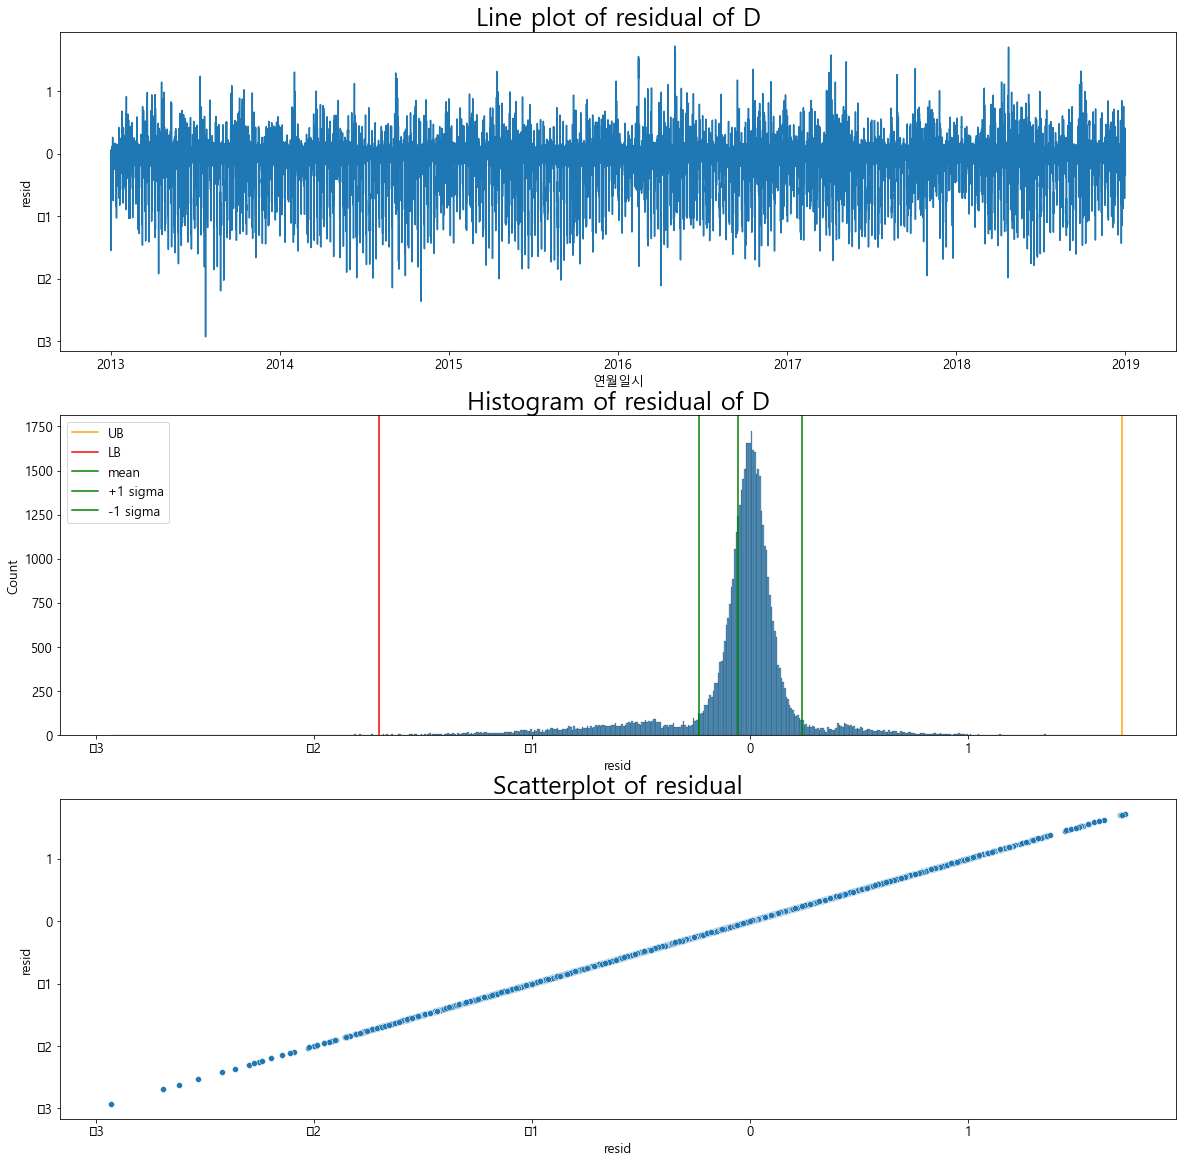

In [187]:
# visualize residuals 

fig, ax = plt.subplots(nrows = 3, ncols =1, figsize = (20, 20))
ax = ax.reshape(3)

sns.lineplot(x= res_robust.resid.index,  y=res_robust.resid, ax = ax[0])
ax[0].set_title("Line plot of residual of D", fontsize = 25)


sns.histplot(res_robust.resid, ax = ax[1])
ax[1].set_title("Histogram of residual of D", fontsize = 25)
ax[1].axvline(mean+(std*6), 0, 1750, color = 'orange', label = 'UB')
ax[1].axvline(-(mean+(std*6)), 0, 1750, color = 'red', label = 'LB')
ax[1].axvline(mean, 0, 1750, color = 'green', label = 'mean')
ax[1].axvline((mean+(std*1)), 0, 1750, color = 'green', label = '+1 sigma')
ax[1].axvline(-(mean+(std*1)), 0, 1750, color = 'green', label = '-1 sigma')




ax[1].legend()

sns.scatterplot(res_robust.resid, res_robust.resid, ax = ax[2])
ax[2].set_title("Scatterplot of residual", fontsize = 25)


### 이상치 index 뽑기 D

In [194]:
test1 = res_robust.resid

outlier_D_index = [test1[test1 == item] for item in outlier_D]
outlier_D_index

[연월일시
 2013-04-14 06:00:00   -1.924375
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 09:00:00   -2.422619
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 10:00:00   -2.255506
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 11:00:00   -2.300158
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 12:00:00   -2.239819
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 13:00:00   -2.275466
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 14:00:00   -2.620731
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 15:00:00   -2.933607
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 16:00:00   -2.696184
 Name: resid, dtype: float64,
 연월일시
 2013-07-24 17:00:00   -2.531691
 Name: resid, dtype: float64,
 연월일시
 2013-08-12 02:00:00   -1.858046
 Name: resid, dtype: float64,
 연월일시
 2013-08-26 01:00:00   -1.917445
 Name: resid, dtype: float64,
 연월일시
 2013-08-26 02:00:00   -2.197453
 Name: resid, dtype: float64,
 연월일시
 2013-09-02 01:00:00   -2.026706
 Name: resid, dtype: float64,
 연월일시
 2014-05-25 07:00:00   -1.89

In [123]:
outlier_D_index = [res_robust.resid.index[item] for item in outlier_D]
outlier_D_index

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

###  STL Forecast

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast

In [40]:
df_D = comp_dct['D']['공급량']

C:\Users\user\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


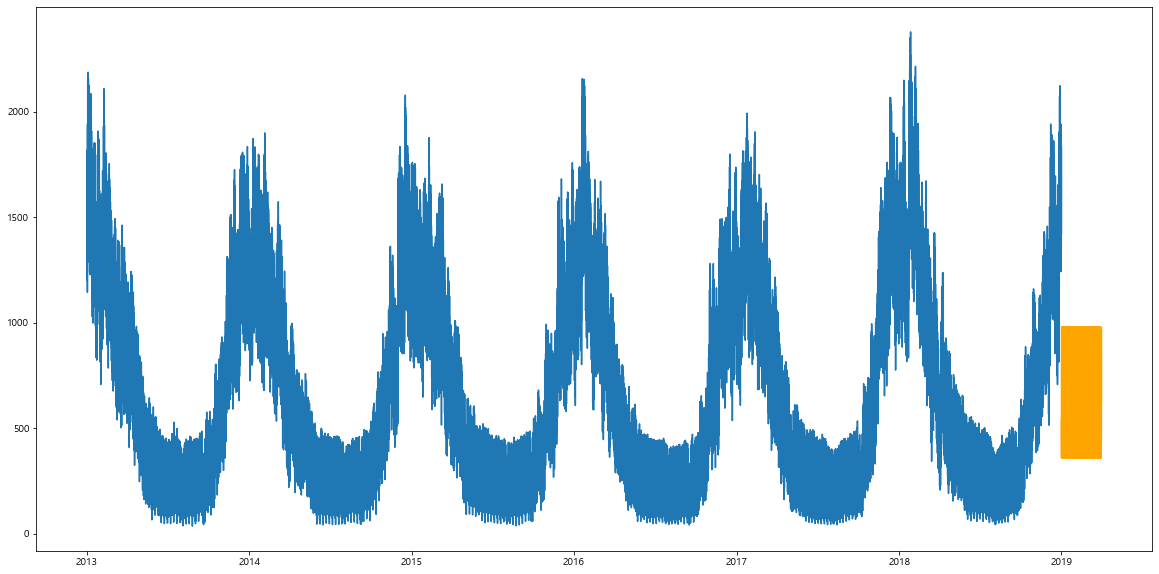

In [53]:

stlf = STLForecast(df_D, ARIMA)
stlf_res = stlf.fit()
plt.figure(figsize =(20,10))
forecast = stlf_res.forecast(2160)
plt.plot(df_D)
plt.plot(forecast, color = 'orange')

plt.show()

### Custom Decomposition using multiple MAs

In [14]:
# 후보 주기
period_sr = [2, 24, 24*7, 24*7*52]

Text(0.5, 0.95, 'A 공급사의 주기별 smoothing 결과')

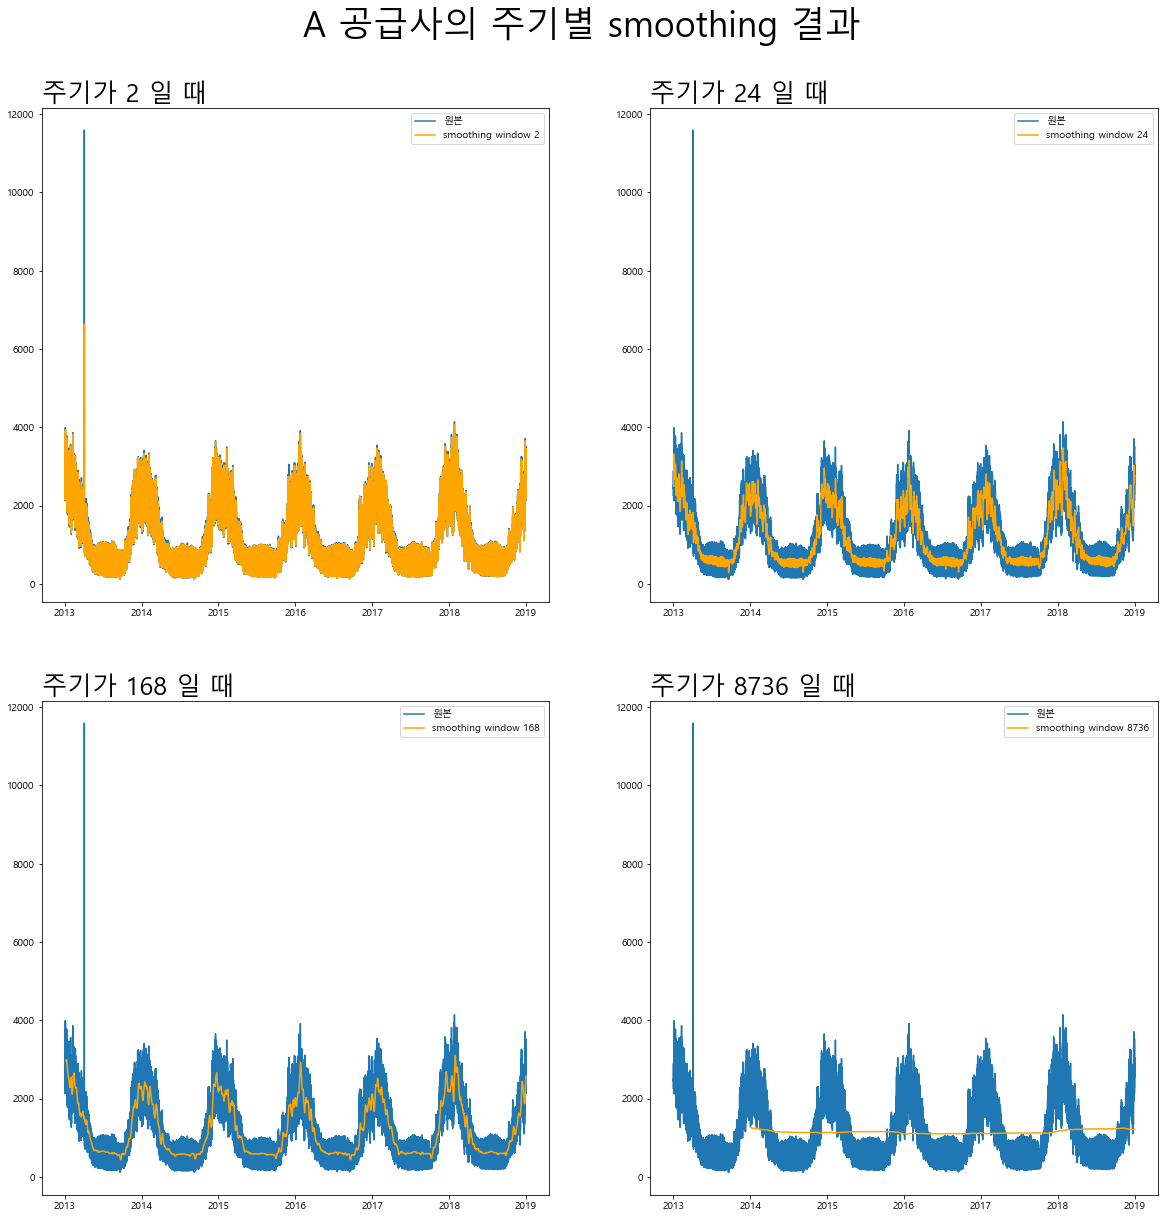

In [27]:
# 주기 별로 smoothing 한 그래프 출력
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))
ax = ax.reshape(4)
for idx, pr in enumerate(period_sr):
    ax[idx].plot(df_A, label = '원본')
    ax[idx].plot(df_A.rolling(window = pr).mean(), c= 'orange', label = f'smoothing window {pr}')
    ax[idx].set_title(f"주기가 {pr} 일 때", fontsize = 25, loc = 'left')
    ax[idx].legend()
plt.suptitle('A 공급사의 주기별 smoothing 결과', fontsize = 35, y = 0.95)


Text(0.5, 0.95, 'B 공급사 주기별 smoothing 결과')

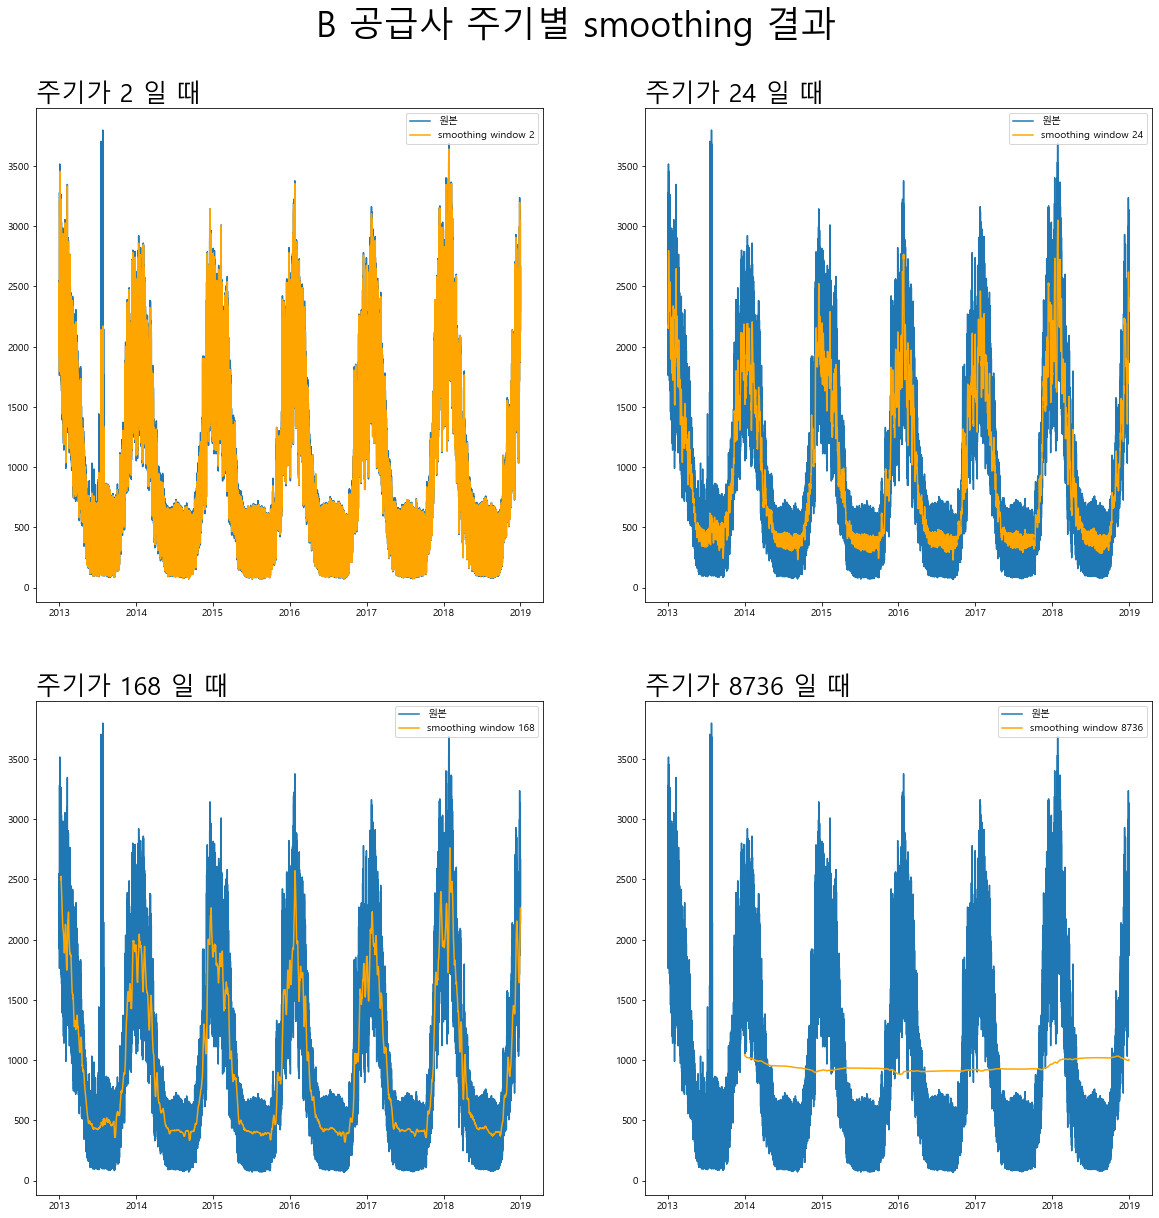

In [36]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 20))
ax = ax.reshape(4)
for idx, pr in enumerate(period_sr):
    ax[idx].plot(comp_dct['B']['공급량'], label = '원본')
    ax[idx].plot(comp_dct['B']['공급량'].rolling(window = pr).mean(), c= 'orange', label = f'smoothing window {pr}')
    ax[idx].set_title(f"주기가 {pr} 일 때", fontsize = 25, loc = 'left')
    ax[idx].legend(loc = 'upper right')
plt.suptitle("B 공급사 주기별 smoothing 결과", fontsize = 35, y = 0.95)

# 4. ANOVA 분석 
- 연도별로 각 공급량의 뚜렷한 차이가 없어보임 -> 따라서 outlier dectection 을 제외하고 decompose and model building 할 때, 마지막 년도만 해도 될것 같음
- 이를 위해 각 년도별 집단의 분포가 큰차이가 없다는 검정 필요

In [33]:
test_df = pd.DataFrame(columns = ['A'])

In [35]:
test_df

,A
0,1
3,1
